# Machine Learning
---------


### Author Information
**Author:** PJ Gibson  
**Email:** Peter.Gibson@doh.wa.gov  
**Github:**   https://github.com/DOH-PJG1303

### Project Information
**Created Date:** 2023-05-27  
**Last Updated:** 2023-05-27  
**Version:** 1  

### Description
This notebook should serve to educate newcomers to Python on simple Machine Learning techniques in the context of Record Linkage.

### Notes


## 1. Import Libraries

In [37]:
# Standard data analysis tools
import pandas as pd
import numpy as np

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Prep Data

### 2.1 Read in data

In [38]:
df_synthetic1 = pd.read_csv('Data/synthetic_df1.csv', dtype=str)
df_synthetic1[['ssn','fname','lname','dob','phone','add']].drop_duplicates('ssn').sort_values('ssn').head(5)

,ssn,fname,lname,dob,phone,add
34023,001-09-4478,LILY,RIVERA,2013-03-27,5417131282,55443 Bates Rd
15920,001-09-7165,AMY,STOWE,2021-04-13,5415064522,232 Lakewood Dr
25546,001-10-0057,RAYMOND,CARRERA,2016-10-16,5412601818,224 S 2nd St APT 128
68611,001-10-5659,BELLA,NORCROSS,2019-10-07,5413280811,1012 Newport Ave SW
45096,001-31-2075,KENDRICK,ALBERT,2020-07-28,5415429680,136 Brummit Creek Rd


In [39]:
df_synthetic2 = pd.read_csv('Data/synthetic_df2.csv', dtype=str)
df_synthetic2[['ssn','fname','lname','dob','phone','add']].drop_duplicates('ssn').sort_values('ssn').head(5)

,ssn,fname,lname,dob,phone,add
78216,001-09-4478,LILY,RIVERA,2013-03-27,(541)-713-1282,55443 Bates Rd
3252,001-09-7165,AMY,STOWE,2021-04-13,(541)-506-4522,232 Lakewood Dr
73192,001-10-0057,RAY,CARRERA,2016-10-16,(541)-260-1818,None
22472,001-10-5659,BELLA,NORCROSS,2019-10-07,(541)-328-0811,1012 Newport Ave SW
15870,001-31-2075,KENDRICCK,ALBERT,2020-07-28,(541)-542-9680,136 Brummit Creek Rd


In [40]:
df_training = pd.read_csv('Data/synthetic_training_data.csv',index_col=[0,1])
df_training.head(5)

,,fname,lname,dob,add,phone,label
18746,30015,0.436508,0.455556,0.516667,0.501587,0.1,0
86617,94840,0.388889,0.000000,0.677778,0.483041,0.0,0
71979,17903,0.000000,0.000000,0.666667,0.489021,0.1,0
10247,97105,0.436508,0.412698,0.600000,0.432540,0.1,0
101953,44150,0.000000,0.441667,0.622222,0.500595,0.1,0


### 2.2 Test Train Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_training.drop('label',axis=1), df_training['label'], test_size=0.2, random_state=42)

## 3. Machine Learning Training

### Decision Tree


#### Notes on parameter tuning
----- 

Parameter tuning in machine learning is the process of selecting the appropriate set of optimal parameters for a model in order to improve its accuracy or other metrics. In the case of the Decision Tree, the parameters we are tuning are 'max_depth' and 'criterion'.

'max_depth' is the maximum depth of the tree. It is used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample.
'criterion' is the function to measure the quality of a split. Sklearn supports “gini” for the Gini impurity and “entropy” for the information gain.
GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.

In our code, we used GridSearchCV with 5-fold cross-validation for the hyperparameter tuning of our Decision Tree model. This means the training set is split into 5 parts and the model will be trained and validated 5 times to get a better estimate of the model performance.

After identifying the best parameters using GridSearchCV, the model is evaluated on the test data. Evaluation metrics like the classification report and confusion matrix provide comprehensive insights about model performance. The classification report shows precision, recall, f1-score, and support for each class while the confusion matrix visualizes the correct predictions and the errors made by the model.

In [42]:
# Define parameter grid
param_grid = {'max_depth': range(1, 5), 'criterion': ['gini', 'entropy']}

# Initialize a DecisionTreeClassifier
dt = DecisionTreeClassifier()

# Initialize GridSearchCV
grid = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 5)},
             scoring='accuracy')

## 4. Visualizations

### 4.1 Parameters

In [43]:
# Print the best parameters
print(f"Best parameters: {grid.best_params_}")

# Predict on the test data
y_pred = grid.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Print accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Best parameters: {'criterion': 'entropy', 'max_depth': 4}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19802
           1       0.99      0.99      0.99     19887

    accuracy                           0.99     39689
   macro avg       0.99      0.99      0.99     39689
weighted avg       0.99      0.99      0.99     39689

Accuracy: 0.9917609413187533


### 4.2 Confusion Matrix

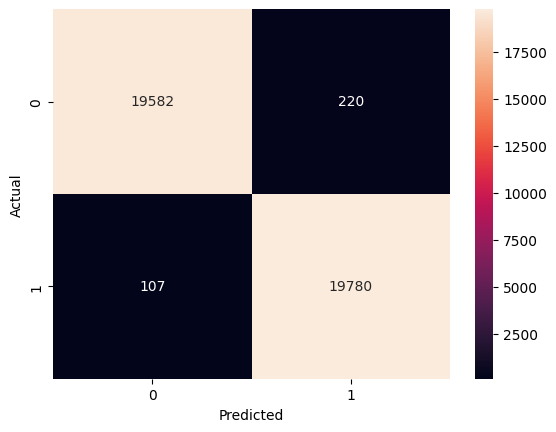

In [44]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 4.3 Decision Tree Plot

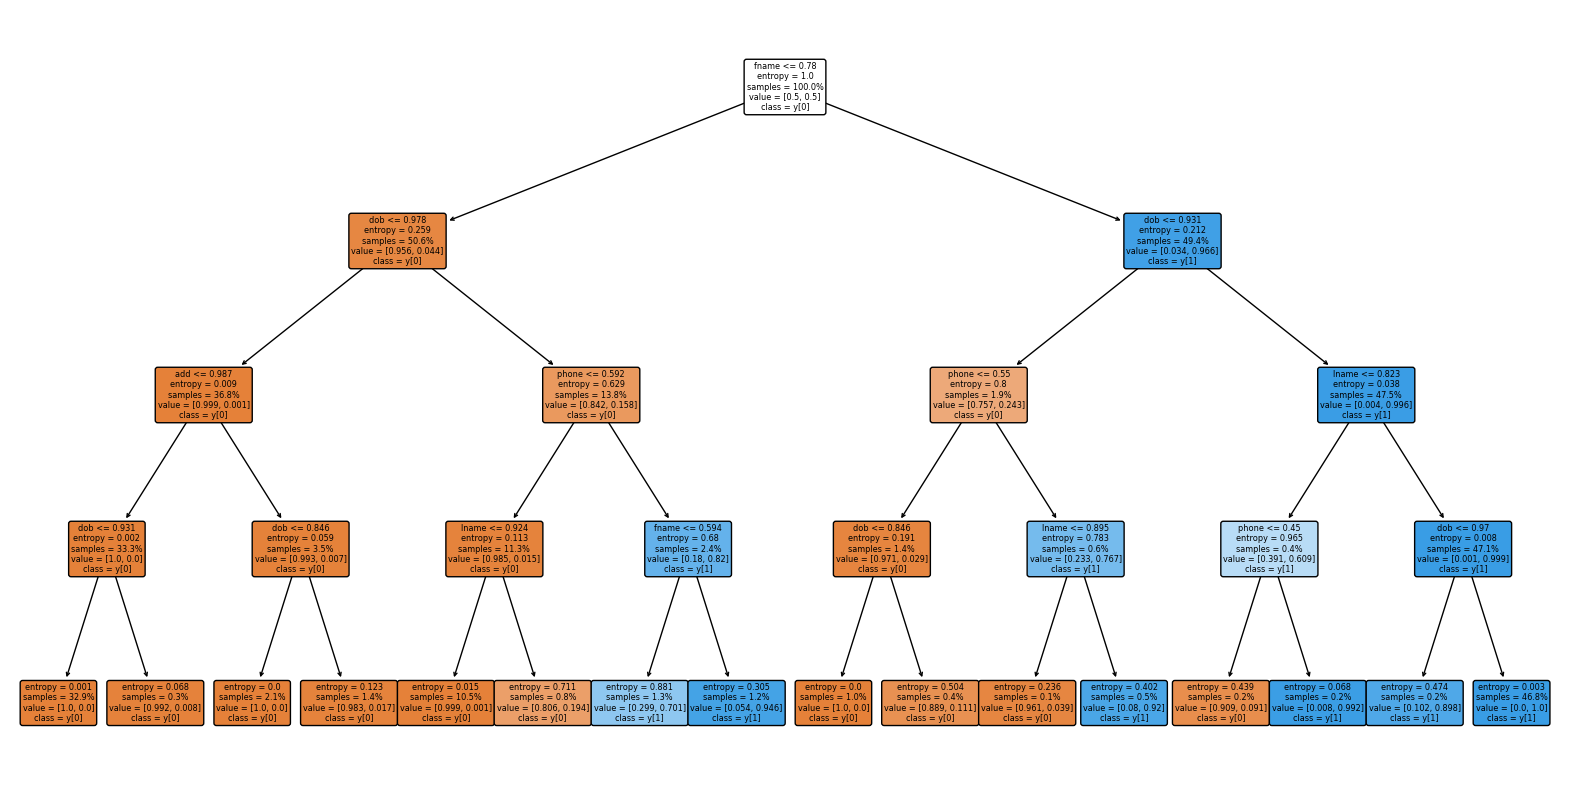

In [45]:
# Assuming grid.best_estimator_ is your trained DecisionTreeClassifier
dt_best = grid.best_estimator_

# Set larger figure size
plt.figure(figsize=(20,10))

# Plot the tree
plot_tree(dt_best, filled=True, rounded=True, feature_names=X_train.columns, class_names=True, proportion=True)

# Show the plot
plt.show()

### 4.4 Manually inspect wrong decisions

This chunk identifies the misclassified examples from a machine learning model's predictions and prints out some examples of these incorrectly classified instances
It's a good way to analyze where the model is going wrong.

In [46]:
# Compare the predicted values (y_pred) with the actual test values (y_test)
# and store the boolean result in list_results (True where prediction is correct, False where incorrect)
list_results = y_pred == y_test

# Extract the indices where the predicted values didn't match the actual test values
wrong_guess_indices = list_results[list_results == False].index

# Use these indices to get the corresponding rows from the training data
wrong_responses = df_training.loc[wrong_guess_indices]

# Split the incorrectly predicted data into two parts: one where the actual label is 0 and one where the actual label is 1
wrong_responses_label0 = wrong_responses.query('label == 0')
wrong_responses_label1 = wrong_responses.query('label == 1')

# List of columns that are used in the analysis
used_cols = ['ssn','fname','lname','dob','phone','add']

# Number of examples to print from each class
num_examples_printed_each_class = 2

# Loop through the number of examples to be printed
for i in range(0,num_examples_printed_each_class):
    # Get the indices for the original dataframes (df_synthetic1 and df_synthetic2) for the misclassified examples where actual label is 0
    df1_index = wrong_responses_label0.iloc[i].name[0]
    df2_index = wrong_responses_label0.iloc[i].name[1]

    # Use these indices to fetch the corresponding rows from the original dataframes
    part1 = df_synthetic1.loc[int(df1_index)][used_cols]
    part2 = df_synthetic2.loc[int(df2_index)][used_cols]

    # Combine the two parts and transpose to get a dataframe with the used_cols as columns
    combined = pd.concat([part1,part2], ignore_index=True, axis=1).transpose()

    # Print and display the misclassified examples where actual label is 0 and model predicted 1
    print('label = 0')
    print('model decision = 1')
    display(combined)
    print('\n\n')

# Similar loop for the misclassified examples where the actual label is 1
for i in range(0,num_examples_printed_each_class):
    # Get the indices for the original dataframes (df_synthetic1 and df_synthetic2) for the misclassified examples where actual label is 1
    df1_index = wrong_responses_label1.iloc[i].name[0]
    df2_index = wrong_responses_label1.iloc[i].name[1]

    # Use these indices to fetch the corresponding rows from the original dataframes
    part1 = df_synthetic1.loc[int(df1_index)][used_cols]
    part2 = df_synthetic2.loc[int(df2_index)][used_cols]

    # Combine the two parts and transpose to get a dataframe with the used_cols as columns
    combined = pd.concat([part1,part2], ignore_index=True, axis=1).transpose()

    # Print and display the misclassified examples where actual label is 1 and model predicted 0
    print('label = 1')
    print('model decision = 0')
    display(combined)
    print('\n\n')

label = 0
model decision = 1


,ssn,fname,lname,dob,phone,add
0,543-93-0658,DYLAN,JACOBS,2010-11-02,5418897027,93651 Dover St
1,543-93-0657,BLAKE,JACOBS,2010-11-02,(541)-889-7027,93651 Dover St





label = 0
model decision = 1


,ssn,fname,lname,dob,phone,add
0,544-42-0902,ALEKSANDRA,HASSELL,2012-07-12,5416080310,1322 Commercial Ave
1,318-40-1228,RY,HASSELL,2012-07-12,(541)-608-0310,None





label = 1
model decision = 0


,ssn,fname,lname,dob,phone,add
0,542-59-4135,TERRY,CORE,1985-12-29,5412033230,19338 Pirelli Ln NE
1,542-59-4135,TERENCE,CORE,NaN,(541)-203-3230,19338 Pirelli Ln NE





label = 1
model decision = 0


,ssn,fname,lname,dob,phone,add
0,543-36-5868,JERRY,MILLIEN,1995-04-07,9713145016,12001 SE River Rd
1,543-36-5868,GERALDINE,MILLIEN,1995-7-4,(971)-314-5016,12001 SE River Rd
